In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2 

%matplotlib inline
import matplotlib.pyplot as plt

import os
import math
from utils.dataloaders import full_onera_loader

In [6]:
DROPOUT = 0.5

class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out):
        super().__init__()
        self.filters_in = filters_in
        self.filters_out = filters_out
        self.conv1 = nn.Conv2d(filters_in, filters_out, (3, 3), padding=1)
        self.norm1 = nn.BatchNorm2d(filters_out)
        self.conv2 = nn.Conv2d(filters_out, filters_out, (3, 3), padding=1)
        self.norm2 = nn.BatchNorm2d(filters_out)

        self.activation = nn.ReLU()

    def forward(self, x):
        conved1 = self.conv1(x)
        conved1 = self.activation(conved1)
        conved1 = self.norm1(conved1)
        conved2 = self.conv2(conved1)
        conved2 = self.activation(conved2)
        conved2 = self.norm2(conved2)
        return conved2

class UNetDownBlock(UNetBlock):
    def __init__(self, filters_in, filters_out, pool=True):
        super().__init__(filters_in, filters_out)
        if pool:
            self.pool = nn.MaxPool2d(2)
        else:
            self.pool = lambda x: x

    def forward(self, x):
        return self.pool(super().forward(x))

class UNetUpBlock(UNetBlock):
    def __init__(self, filters_in, filters_out):
        super().__init__(filters_in, filters_out)
        self.upconv = nn.Conv2d(filters_in, filters_in // 2, (3, 3), padding=1)
        self.upnorm = nn.BatchNorm2d(filters_in // 2)

    def forward(self, x, cross_x1, cross_x2):
        x = F.upsample(x, size=cross_x1.size()[-2:], mode='bilinear')
        x = self.upnorm(self.activation(self.upconv(x)))
        x = torch.cat((x, cross_x1/cross_x2), 1)
        return super().forward(x)

class UNet(nn.Module):
    def __init__(self, layers, init_filters):
        super().__init__()
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()
        self.init_filters = init_filters

        filter_size = init_filters
        for _ in range(layers - 1):
            self.down_layers.append(
                UNetDownBlock(filter_size, filter_size*2)
            )
            filter_size *= 2
        self.down_layers.append(UNetDownBlock(filter_size, filter_size * 2, pool=False))
        for i in range(layers):
            self.up_layers.append(
                UNetUpBlock(filter_size * 2, filter_size)
            )
            filter_size //= 2

        self.data_norm = nn.BatchNorm2d(4)
        self.init_layer = nn.Conv2d(4, init_filters, (7, 7), padding=3)
        self.activation = nn.ReLU()
        self.init_norm = nn.BatchNorm2d(init_filters)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x1, x2):
        x1 = self.data_norm(x1)
        x1 = self.init_norm(self.activation(self.init_layer(x1)))

        x2 = self.data_norm(x2)
        x2 = self.init_norm(self.activation(self.init_layer(x2)))
        
        saved_x = [[x1, x2]]
        for layer in self.down_layers:
            saved_x.append([x1,x2])
            x1 = self.dropout(layer(x1))
            x2 = self.dropout(layer(x2))

        is_first = True
        for layer, saved_x in zip(self.up_layers, reversed(saved_x)):
            if not is_first:
                is_first = False
                x1 = self.dropout(x1)
            x1 = layer(x1, saved_x[0], saved_x[1])
        return x1

class UNetClassify(UNet):
    def __init__(self, *args, **kwargs):
        init_val = kwargs.pop('init_val', 0.5)
        super().__init__(*args, **kwargs)
        self.output_layer = nn.Conv2d(self.init_filters, 1, (3, 3), padding=1)

        for name, param in self.named_parameters():
            typ = name.split('.')[-1]
            if typ == 'bias':
                if 'output_layer' in name:
                    # Init so that the average will end up being init_val
                    param.data.fill_(-math.log((1-init_val)/init_val))
                else:
                    param.data.zero_()

    def forward(self, x1, x2):
        x = super().forward(x1, x2)
        # Note that we don't perform the sigmoid here.
        return self.output_layer(x)

In [8]:
# model = torch.load('../weights/onera/3dconv_seg.pt')
model = UNetClassify(layers=4, init_filters=32, init_val=0.5).cuda()
weights = torch.load('../weights/onera/unet_siamese_div_4band_2dates_dice.pt')
model.load_state_dict(weights)
model.eval()

UNetClassify(
  (down_layers): ModuleList(
    (0): UNetDownBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): UNetDownBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, pa

In [10]:
dataset = full_onera_loader('../datasets/onera/', ['B02','B03','B04','B08'])

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


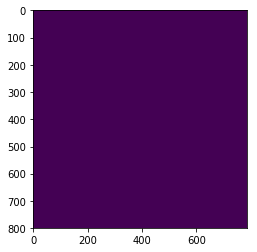

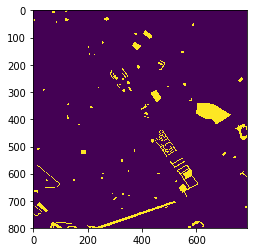

In [15]:
for city in ['abudhabi']:
    img = dataset[city]['images']
    label = dataset[city]['labels']
    out = np.zeros((img.shape[2],img.shape[3]))
    for i in range(0,img.shape[2],32):
        for j in range(0,img.shape[3],32):
            if i + 32 < img.shape[2] and j + 32 < img.shape[3]:
                patch = np.transpose(dataset[city]['images'][:, : ,i:i+32, j:j+32], (1,0,2,3))
                inp1 = torch.from_numpy(np.asarray([patch[0]])).cuda()
                inp2 = torch.from_numpy(np.asarray([patch[1]])).cuda()
                logits = model(inp1, inp2)
#                 print (logits.min(),logits.max())
                pred = F.sigmoid(logits) > 0.1
                pred = pred.data.cpu().numpy()[0]
                out[i:i+32,j:j+32] = pred     
    plt.imshow(out)
    plt.show()
    plt.imshow(label)
    plt.show()
    break